In [2]:
!python -m pip install --upgrade pip setuptools wheel
!pip install swig
!pip install gymnasium
!pip install gymnasium[box2d]
!pip install gymnasium[other]

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


# Basic Usage

In [3]:
import gymnasium as gym
'''
使用make()创建一个环境，并附加一个关键字"render_mode" ，指定如何可视化环境。有关不同渲染模式的默认含义的详细信息，请参阅Env.render() 。在此示例中，我们使用"LunarLander"环境，其中代理控制需要安全着陆的宇宙飞船。
'''
env = gym.make("LunarLander-v3", render_mode="human")


'''
初始化环境后，我们Env.reset()环境以获得对环境的第一次观察以及附加信息。
'''
observation, info = env.reset()

episode_over = False
while not episode_over:
    action = env.action_space.sample()  # agent policy that uses the observation and info
    ''' Env.step()执行选定的操作（在本例中是随机的env.action_space.sample() ）以更新环境。
        代理从更新的环境中收到新的观察结果以及采取行动的 Reward。
        一种这样的动作-观察交换被称为timestep。
        在 Gymnasium 中，如果环境已终止，则由step()返回作为第三个变量terminated
    '''
    observation, reward, terminated, truncated, info = env.step(action)

    episode_over = terminated or truncated

    '''
    用户可能希望重新启动环境，这可以通过env.reset()来完成. 这里我们不reset, 所以会直接退出
    '''

env.close()

每个环境都使用action_space和observation_space属性指定有效操作和观察的格式。

Env.action_space和Env.observation_space是Space的实例，这是一个 python 类，提供关键函数： Space.contains()和Space.sample()

Discrete ：描述一个离散空间，其中{0, 1, ..., n-1}是我们的观察或操作可以采取的可能值。
MultiDiscrete ：由一系列Discrete动作空间组成，每个元素中具有不同数量的动作。

MultiBinary ：描述任意n维形状的二元空间。
Text ：描述具有最小和最大长度的字符串空间。
Dict ：描述更简单空间的字典。
Tuple ：描述简单空间的元组。


Box ：描述任何n维形状的有上限和下限的有界空间。
Graph ：描述具有互连节点和边的数学图（网络）。
Sequence ：描述更简单的空间元素的可变长度。

Wrappers 是修改现有环境的便捷方法，而无需直接更改底层代码。

In [4]:
'''
为了包装环境，您必须首先初始化基础环境。然后，您可以将此环境与（可能是可选的）参数一起传递给wrapper的constructor函数：
'''

import gymnasium as gym
from gymnasium.wrappers import FlattenObservation
env = gym.make("CarRacing-v3")
env.observation_space.shape
(96, 96, 3)

'''用wrapper'''
wrapped_env = FlattenObservation(env)
wrapped_env.observation_space.shape
(27648,)

(27648,)

wrapped_env
<FlattenObservation<TimeLimit<OrderEnforcing<PassiveEnvChecker<CarRacing<CarRacing-v3>

使用unwrapped属性获得所有包装器层下的未包装环境（以便您可以手动调用函数或更改环境的某些底层方面）
wrapped_env.unwrapped
<gymnasium.envs.box2d.car_racing.CarRacing object at 0x7f04efcb8850>

TimeLimit ：如果超过最大时间步数（或者基本环境已发出截断信号），则发出截断信号。

ClipAction ：Clips 传递到step任何操作，使其位于base environment的 action space中。

TimeAwareObservation ：将有关时间步长索引的信息添加到观察中。在某些情况下有助于确保转移是马尔可夫的。

RescaleAction ：对动作应用仿射变换，以线性缩放环境的新下限和上限。

# Training an Agent
use a tabular based Q-learning to solve the Blackjack v1 environment

二十一点 Blackjack 是最受欢迎的赌场纸牌游戏之一.
这个版本的游戏使用**无限牌组**（我们抽出有替换的牌），因此在我们的模拟游戏中**计算牌不是一个可行的策略**。

observation 是 玩家当前总和current sum、庄家面朝上牌的值 以及 玩家是否持有可用箱子的布尔值 的 tuple。代理可以在两个操作之间进行选择：站立 (0)，以便玩家不再拿牌；击打 (1)，以便玩家拿另一张牌。要获胜，您的牌点数应大于庄家且不超过 21。如果玩家选择停牌或牌点数大于 21，则游戏结束。

https://gymnasium.farama.org/environments/toy_text/blackjack.

Q-learning 是 Watkins 于 1989 年提出的一种无模型的离策略学习算法，适用于具有离散动作空间的环境，并因成为第一个证明在某些条件下收敛到最优策略的强化学习算法而闻名。

env.step(action)返回四个有用的变量  next observation ：这是代理在采取操作后将收到的观察。

reward: This is the reward that the agent will receive after taking the action.
reward ：这是代理采取行动后将获得的奖励。

terminated: This is a boolean variable that indicates whether or not the environment has terminated, i.e., ended due to an internal condition.
terminated ：这是一个布尔变量，指示环境是否已终止，即由于内部条件而结束。

truncated: This is a boolean variable that also indicates whether the episode ended by early truncation, i.e., a time limit is reached.
truncated ：这是一个布尔变量，还指示剧集是否通过提前截断结束，即达到时间限制。

info: This is a dictionary that might contain additional information about the environment.
info ：这是一个字典，可能包含有关环境的附加信息。

next observation 、 reward 、 terminated和truncated变量是不言自明的，

但info变量需要一些额外的解释。该变量包含一个字典，其中可能包含一些有关环境的额外信息，但在 Blackjack-v1 环境中您可以忽略它。例如，在 Atari 环境中，信息字典有一个ale.lives键，它告诉我们代理还剩下多少条生命。如果特工的生命为 0，那么这一集就结束了。

# Building an agent 需要一些函数来选择操作并更新代理操作值。为了确保代理探索环境，一种可能的解决方案是 epsilon-greedy 策略，pick a random action with the percentage epsilon and the greedy action (currently valued as the best) 1 - epsilon.

In [5]:
from collections import defaultdict
import gymnasium as gym
import numpy as np


class BlackjackAgent:
    def __init__(
        self,
        env: gym.Env,
        learning_rate: float,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        discount_factor: float = 0.95,
    ):
        """Initialize a Reinforcement Learning agent with an empty dictionary
        of state-action values (q_values), a learning rate and an epsilon.

        Args:
            env: The training environment
            learning_rate: The learning rate
            initial_epsilon: The initial epsilon value
            epsilon_decay: The decay for epsilon
            final_epsilon: The final epsilon value
            discount_factor: The discount factor for computing the Q-value
        """
        self.env = env
        self.q_values = defaultdict(lambda: np.zeros(env.action_space.n))

        self.lr = learning_rate
        self.discount_factor = discount_factor

        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon

        self.training_error = []

    def get_action(self, obs: tuple[int, int, bool]) -> int:
        """
        Returns the best action with probability (1 - epsilon)
        otherwise a random action with probability epsilon to ensure exploration.
        """
        # with probability epsilon return a random action to explore the environment
        if np.random.random() < self.epsilon:
            return self.env.action_space.sample()
        # with probability (1 - epsilon) act greedily (exploit)
        else:
            return int(np.argmax(self.q_values[obs]))

    def update(
        self,
        obs: tuple[int, int, bool],
        action: int,
        reward: float,
        terminated: bool,
        next_obs: tuple[int, int, bool],
    ):
        """Updates the Q-value of an action."""
        future_q_value = (not terminated) * np.max(self.q_values[next_obs])
        temporal_difference = (
            reward + self.discount_factor * future_q_value - self.q_values[obs][action]
        )

        self.q_values[obs][action] = (
            self.q_values[obs][action] + self.lr * temporal_difference
        )

        self.training_error.append(temporal_difference)

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)

Training the agent  To train the agent, we will let the agent play one episode (one complete game is called an episode) at a time and then update it’s Q-values after each episode. The agent will have to experience a lot of episodes to explore the environment sufficiently.我们将让智能体一次玩一episode（一个完整的游戏称为一集），然后在每一集后更新它的 Q-values。智能体必须经历很多episodes才能充分探索环境。

In [6]:
# hyperparameters
learning_rate = 0.01
n_episodes = 100_000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.1

env = gym.make("Blackjack-v1", sab=False)
env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=n_episodes)

agent = BlackjackAgent(
    env=env,
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
)

In [7]:
from tqdm import tqdm

for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    done = False

    # play one episode
    while not done:
        action = agent.get_action(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)

        # update the agent
        agent.update(obs, action, reward, terminated, next_obs)

        # update if the environment is done and the current obs
        done = terminated or truncated
        obs = next_obs

    agent.decay_epsilon()

  0%|          | 0/100000 [00:00<?, ?it/s]

100%|██████████| 100000/100000 [00:05<00:00, 17421.26it/s]


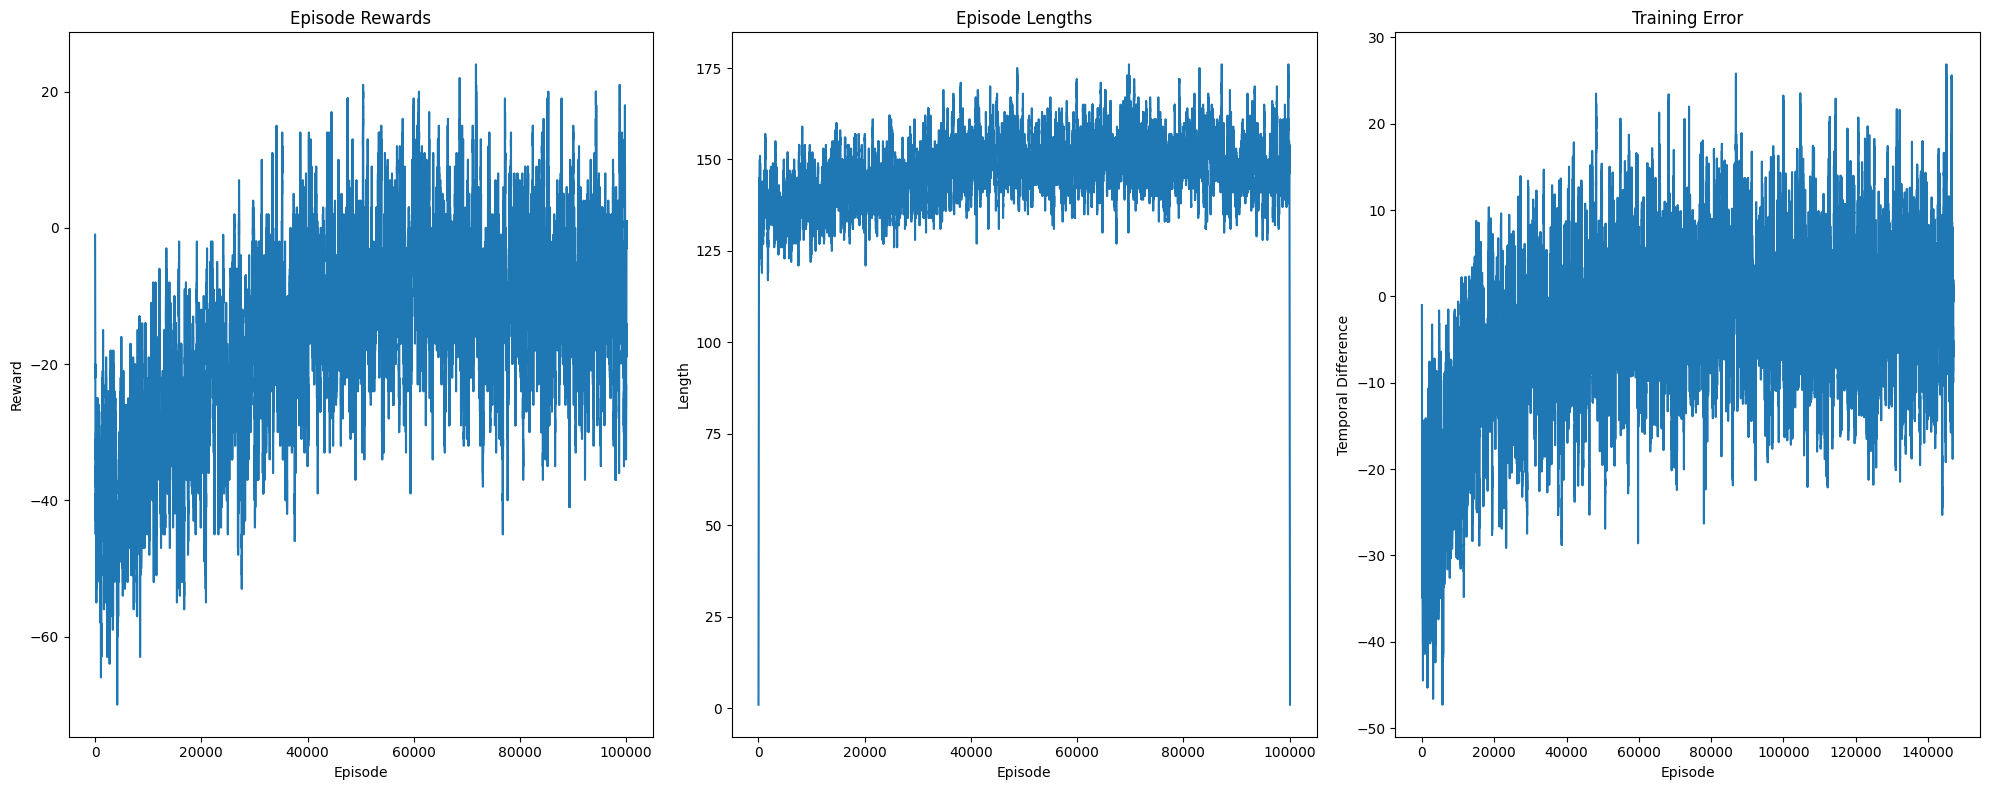

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch

# visualize the episode rewards, episode length and training error in one figure
fig, axs = plt.subplots(1, 3, figsize=(20, 8))

# np.convolve will compute the rolling mean for 100 episodes

axs[0].plot(np.convolve(env.return_queue, np.ones(100)))
axs[0].set_title("Episode Rewards")
axs[0].set_xlabel("Episode")
axs[0].set_ylabel("Reward")

axs[1].plot(np.convolve(env.length_queue, np.ones(100)))
axs[1].set_title("Episode Lengths")
axs[1].set_xlabel("Episode")
axs[1].set_ylabel("Length")

axs[2].plot(np.convolve(agent.training_error, np.ones(100)))
axs[2].set_title("Training Error")
axs[2].set_xlabel("Episode")
axs[2].set_ylabel("Temporal Difference")

plt.tight_layout()
plt.show()

## Visualising the policy

NameError: name 'Patch' is not defined

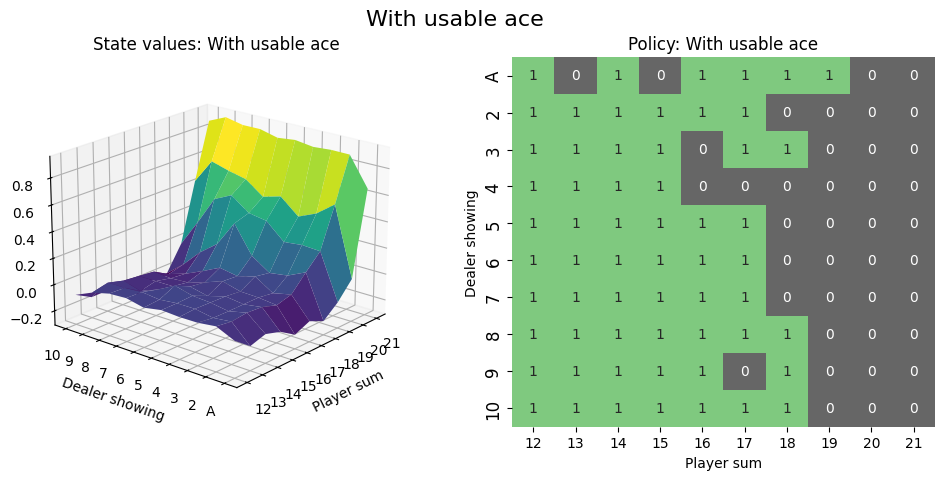

In [11]:
def create_grids(agent, usable_ace=False):
    """Create value and policy grid given an agent."""
    # convert our state-action values to state values
    # and build a policy dictionary that maps observations to actions
    state_value = defaultdict(float)
    policy = defaultdict(int)
    for obs, action_values in agent.q_values.items():
        state_value[obs] = float(np.max(action_values))
        policy[obs] = int(np.argmax(action_values))

    player_count, dealer_count = np.meshgrid(
        # players count, dealers face-up card
        np.arange(12, 22),
        np.arange(1, 11),
    )

    # create the value grid for plotting
    value = np.apply_along_axis(
        lambda obs: state_value[(obs[0], obs[1], usable_ace)],
        axis=2,
        arr=np.dstack([player_count, dealer_count]),
    )
    value_grid = player_count, dealer_count, value

    # create the policy grid for plotting
    policy_grid = np.apply_along_axis(
        lambda obs: policy[(obs[0], obs[1], usable_ace)],
        axis=2,
        arr=np.dstack([player_count, dealer_count]),
    )
    return value_grid, policy_grid


def create_plots(value_grid, policy_grid, title: str):
    """Creates a plot using a value and policy grid."""
    # create a new figure with 2 subplots (left: state values, right: policy)
    player_count, dealer_count, value = value_grid
    fig = plt.figure(figsize=plt.figaspect(0.4))
    fig.suptitle(title, fontsize=16)

    # plot the state values
    ax1 = fig.add_subplot(1, 2, 1, projection="3d")
    ax1.plot_surface(
        player_count,
        dealer_count,
        value,
        rstride=1,
        cstride=1,
        cmap="viridis",
        edgecolor="none",
    )
    plt.xticks(range(12, 22), range(12, 22))
    plt.yticks(range(1, 11), ["A"] + list(range(2, 11)))
    ax1.set_title(f"State values: {title}")
    ax1.set_xlabel("Player sum")
    ax1.set_ylabel("Dealer showing")
    ax1.zaxis.set_rotate_label(False)
    ax1.set_zlabel("Value", fontsize=14, rotation=90)
    ax1.view_init(20, 220)

    # plot the policy
    fig.add_subplot(1, 2, 2)
    ax2 = sns.heatmap(policy_grid, linewidth=0, annot=True, cmap="Accent_r", cbar=False)
    ax2.set_title(f"Policy: {title}")
    ax2.set_xlabel("Player sum")
    ax2.set_ylabel("Dealer showing")
    ax2.set_xticklabels(range(12, 22))
    ax2.set_yticklabels(["A"] + list(range(2, 11)), fontsize=12)

    # add a legend
    legend_elements = [
        Patch(facecolor="lightgreen", edgecolor="black", label="Hit"),
        Patch(facecolor="grey", edgecolor="black", label="Stick"),
    ]
    ax2.legend(handles=legend_elements, bbox_to_anchor=(1.3, 1))
    return fig


# state values & policy with usable ace (ace counts as 11)
value_grid, policy_grid = create_grids(agent, usable_ace=True)
fig1 = create_plots(value_grid, policy_grid, title="With usable ace")
plt.show()

# Create a Custom Environment 创建自定义环境
GridWorldEnv ，由固定大小的二维方形网格组成。代理可以在每个时间步长的网格单元之间垂直或水平移动，代理的目标是导航到在剧集开始时随机放置的网格上的目标。

# Basic information about the game

Observations提供了target和agent的位置。

我们的环境中有 4 个离散动作，分别对应于“右”、“上”、“左”和“下”运动。
当代理导航到目标所在的网格单元时，环境结束（terminates）。
智能体仅在达到目标时才获得奖励，即当智能体达到目标时奖励为 1，否则奖励为零。

## Environment __init__
我们的自定义环境将继承自gymnasium.Env，它定义了环境的结构。
环境的要求之一是定义观察和行动空间，它声明环境的可能输入（actions）和输出（observations）的一般集合。正如我们关于游戏的基本信息中所述，我们的代理有四个离散动作，因此我们将使用具有四个选项的Discrete(4)空间。                              

在本教程中，我们将想象我们的观察看起来像 {"agent": array([1, 0]), "target": array([0, 3])} 其中数组元素表示代理或目标的 x 和 y 位置。用于表示观察的替代选项是 2d grid，其值表示网格上的代理和目标，或 3d grid，每个“层”仅包含代理或目标信息。因此，我们将观察空间声明为Dict ，代理空间和目标空间声明为Box ，允许 int 类型的数组输出。

In [ ]:
from typing import Optional
import numpy as np
import gymnasium as gym


class GridWorldEnv(gym.Env):

    def __init__(self, size: int = 5):
        # The size of the square grid
        self.size = size

        # Define the agent and target location; randomly chosen in `reset` and updated in `step`
        self._agent_location = np.array([-1, -1], dtype=np.int32)
        self._target_location = np.array([-1, -1], dtype=np.int32)

        # Observations are dictionaries with the agent's and the target's location.
        # Each location is encoded as an element of {0, ..., `size`-1}^2
        self.observation_space = gym.spaces.Dict(
            {
                "agent": gym.spaces.Box(0, size - 1, shape=(2,), dtype=int),
                "target": gym.spaces.Box(0, size - 1, shape=(2,), dtype=int),
            }
        )

        # We have 4 actions, corresponding to "right", "up", "left", "down"
        self.action_space = gym.spaces.Discrete(4)
        # Dictionary maps the abstract actions to the directions on the grid
        self._action_to_direction = {
            0: np.array([1, 0]),  # right
            1: np.array([0, 1]),  # up
            2: np.array([-1, 0]),  # left
            3: np.array([0, -1]),  # down
        }

## Constructing Observations

由于我们需要在Env.reset()和Env.step()中计算观测值，因此使用_get_obs方法将环境状态转换为观测值通常很方便。但是，这不是强制性的，您可以分别计算Env.reset()和Env.step()中的观测值。

In [ ]:
def _get_obs(self):
    return {"agent": self._agent_location, "target": self._target_location} 

def _get_info(self): #提供代理和目标之间的曼哈顿距离
    return {
        "distance": np.linalg.norm(
            self._agent_location - self._target_location, ord=1
        )
    }

## Reset function

由于reset()的目的是为环境启动一个新的episode，并且有两个参数： seed和options 。种子可用于将随机数生成器初始化为确定性状态，并且选项可用于指定重置中使用的值。

在重置的第一行，您需要调用super().reset(seed=seed) ，它将初始化随机数生成 ( np_random ) 以在reset()的其余部分中使用。

在我们的自定义环境中， reset()需要随机选择代理和目标的位置（如果它们具有相同的位置，我们会重复此操作）。

reset()的返回类型是初始观察和任何辅助信息的元组。因此，我们可以使用之前实现的_get_obs和_get_info方法：

In [ ]:
def reset(self, seed: Optional[int] = None, options: Optional[dict] = None):
    # We need the following line to seed self.np_random
    super().reset(seed=seed)

    # Choose the agent's location uniformly at random
    self._agent_location = self.np_random.integers(0, self.size, size=2, dtype=int)

    # We will sample the target's location randomly until it does not coincide with the agent's location
    self._target_location = self._agent_location
    while np.array_equal(self._target_location, self._agent_location):
        self._target_location = self.np_random.integers(
            0, self.size, size=2, dtype=int
        )

    observation = self._get_obs()
    info = self._get_info()

    return observation, info

## Step function

step()方法通常包含环境的大部分逻辑，它接受一个action并在应用该操作后计算环境的状态，返回下一个观察的元组，如果环境已终止，则返回结果奖励，如果环境有截断和辅助信息。


我们使用 self._action_to_direction **将离散动作（例如 2）转换为具有代理位置的网格方向**。为了防止代理超出网格范围，我们剪切代理的位置以使其保持在边界内。

我们通过检查智能体的当前位置是否等于目标位置来**计算智能体的奖励**。

由于环境不会在内部截断truncate（我们可以在 :meth:make 期间对环境应用时间限制包装器），因此我们将 truncated 永久设置为 False。

我们再次使用_get_obs和_get_info来获取代理的观察和辅助信息。

In [ ]:
def step(self, action):
    # Map the action (element of {0,1,2,3}) to the direction we walk in
    direction = self._action_to_direction[action]
    # We use `np.clip` to make sure we don't leave the grid bounds
    self._agent_location = np.clip(
        self._agent_location + direction, 0, self.size - 1
    )

    # An environment is completed if and only if the agent has reached the target
    terminated = np.array_equal(self._agent_location, self._target_location)
    truncated = False
    reward = 1 if terminated else 0  # the agent is only reached at the end of the episode
    observation = self._get_obs()
    info = self._get_info()

    return observation, reward, terminated, truncated, info

## Registering and making the environment

虽然现在可以立即使用新的自定义环境，但更常见的是使用gymnasium.make()初始化环境。

Register 还有额外的参数，可用于指定环境的关键字参数，例如，是否应用时间限制包装器等。有关更多信息，请参阅gymnasium.register() 。

In [ ]:
gym.register(
    id="gymnasium_env/GridWorld-v0",
    entry_point=GridWorldEnv,
)

注册环境后，您可以通过gymnasium.pprint_registry()进行检查，它将输出所有注册的环境，然后可以使用gymnasium.make()初始化环境。可以使用gymnasium.make_vec()实例化具有并行运行的同一环境的多个实例的环境的矢量化版本。

In [ ]:
import gymnasium as gym
>>> gym.make("gymnasium_env/GridWorld-v0")
<OrderEnforcing<PassiveEnvChecker<GridWorld<gymnasium_env/GridWorld-v0>>>>
>>> gym.make("gymnasium_env/GridWorld-v0", max_episode_steps=100)
<TimeLimit<OrderEnforcing<PassiveEnvChecker<GridWorld<gymnasium_env/GridWorld-v0>>>>>
>>> env = gym.make("gymnasium_env/GridWorld-v0", size=10)
>>> env.unwrapped.size
10
>>> gym.make_vec("gymnasium_env/GridWorld-v0", num_envs=3)
SyncVectorEnv(gymnasium_env/GridWorld-v0, num_envs=3)

SyntaxError: invalid syntax (1044497010.py, line 3)

## Using Wrappers
通常，我们想要使用自定义环境的不同变体，或者我们想要修改 Gymnasium 或其他方提供的环境的行为。包装器允许我们在不改变环境实现或添加任何样板代码的情况下做到这一点。查看包装器文档，了解如何使用包装器的详细信息以及实现您自己的包装器的说明。在我们的示例中，观察结果不能直接用于学习代码，因为它们是字典。然而，我们实际上不需要修改我们的环境实现来解决这个问题！我们可以简单地在环境实例之上添加一个包装器，将观察结果扁平化为单个数组：

In [ ]:
from gymnasium.wrappers import FlattenObservation

env = gym.make('gymnasium_env/GridWorld-v0')
env.observation_space
Dict('agent': Box(0, 4, (2,), int64), 'target': Box(0, 4, (2,), int64))
env.reset()
({'agent': array([4, 1]), 'target': array([2, 4])}, {'distance': 5.0})
wrapped_env = FlattenObservation(env)
wrapped_env.observation_space
Box(0, 4, (4,), int64)
wrapped_env.reset()
(array([3, 0, 2, 1]), {'distance': 2.0})

SyntaxError: invalid syntax (3205450969.py, line 5)

# Recording Agents
在训练期间或评估智能体时，记录智能体在一个情节中的行为并记录累积的总奖励可能会很有趣。这可以通过两个包装器来实现： RecordEpisodeStatistics和RecordVideo ，第一个包装器跟踪剧集数据，例如总奖励、剧集长度和所用时间，第二个包装器使用环境渲染生成代理的 mp4 视频。

## Recording Every **Episode**

In [ ]:
import gymnasium as gym
from gymnasium.wrappers import RecordEpisodeStatistics, RecordVideo

num_eval_episodes = 4

env = gym.make("CartPole-v1", render_mode="rgb_array")  # replace with your environment
env = RecordVideo(env, video_folder="cartpole-agent", name_prefix="eval",
                  episode_trigger=lambda x: True)
env = RecordEpisodeStatistics(env, buffer_length=num_eval_episodes)

for episode_num in range(num_eval_episodes):
    obs, info = env.reset()

    episode_over = False
    while not episode_over:
        action = env.action_space.sample()  # replace with actual agent
        obs, reward, terminated, truncated, info = env.step(action)

        episode_over = terminated or truncated
env.close()

print(f'Episode time taken: {env.time_queue}')
print(f'Episode total rewards: {env.return_queue}')
print(f'Episode lengths: {env.length_queue}')

C:\Users\gaojin\AppData\Roaming\Python\Python312\site-packages\gymnasium\wrappers\rendering.py:283: UserWarning: WARN: Overwriting existing videos at f:\GitHub\6S890_Project\cartpole-agent folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Episode time taken: deque([0.026237, 0.08763, 0.055395, 0.051771], maxlen=4)
Episode total rewards: deque([9.0, 38.0, 22.0, 19.0], maxlen=4)
Episode lengths: deque([9, 38, 22, 19], maxlen=4)


## Recording the Agent during **Training**

在训练期间，智能体将在数百或数千个情节中进行操作，因此，您无法为每个情节录制视频，但开发人员可能仍然想知道智能体在训练中的不同点上的行为，在训练期间定期记录情节。而对于episode统计，了解每一集的这些数据会更有帮助。下面的脚本提供了一个示例，说明如何定期记录代理的剧集，同时记录每个剧集的统计信息（我们使用 python 的记录器，但可以使用tensorboard 、 wandb和其他模块）。

In [ ]:
import logging

import gymnasium as gym
from gymnasium.wrappers import RecordEpisodeStatistics, RecordVideo

training_period = 250  # record the agent's episode every 250
num_training_episodes = 10_000  # total number of training episodes

env = gym.make("CartPole-v1", render_mode="rgb_array")  # replace with your environment
env = RecordVideo(env, video_folder="cartpole-agent", name_prefix="training",
                  episode_trigger=lambda x: x % training_period == 0)
env = RecordEpisodeStatistics(env)

for episode_num in range(num_training_episodes):
    obs, info = env.reset()

    episode_over = False
    while not episode_over:
        action = env.action_space.sample()  # replace with actual agent
        obs, reward, terminated, truncated, info = env.step(action)

        episode_over = terminated or truncated

    logging.info(f"episode-{episode_num}", info["episode"])
env.close()

# Speeding Up Training
加速训练的一般策略：矢量化环境、优化训练和算法启发式。
vectorizing environments, optimizing training and algorithmic heuristics.

## Vectorized environments
通常在训练中，代理将从 单个环境 中进行采样，将 number of steps (samples) per second 限制为环境的速度。通过**同时在多个环境中进行操作**（称为**矢量化环境**，其中同一环境的多个实例并行运行（在多个 CPU 上）），可以大大提高训练效果。 

Gymnasium 提供了两个内置类来矢量化大多数通用环境：
gymnasium.vector.SyncVectorEnv 和 gymnasium.vector.AsyncVectorEnv 

可以使用gymnasium.make_vec()轻松创建。

应该注意的是，矢量化环境可能需要更改训练算法，并且可能会导致有大量子环境的训练不稳定。

## Optimizing training
通常可以通过优化代码来加快训练速度，特别是对于在训练中使用 GPU 的深度强化学习，因为需要在 RAM 和 GPU 内存之间传输数据。
对于用 PyTorch 和 Jax 编写的代码，它们提供了对 CPU、GPU 和 TPU（对于 jax）的代码顺序jit （即时编译）的能力，以减少训练时间。

## Algorithmic heuristics
学术研究人员不断探索新的优化，以提高代理性能并减少训练代理所需的样本数量。特别是，样本高效强化学习是强化学习的一个专业子领域，它探索训练算法和环境启发式的优化，以减少代理观察所需的数量，从而最大限度地提高性能。随着该领域不断进步，我们建议读者查找调查论文和最新研究，以了解当前存在的最有效的算法改进是什么。

# Seed and random number generator
种子和随机数生成器

The Env.seed() has been removed from the Gym v0.26 environments in favour of **Env.reset(seed=seed)**

这使得seeding只能在环境重置时更改。删除seed的决定是因为某些环境使用的模拟器无法在剧集内更改随机数生成器，并且必须在新剧集开始时完成。我们知道控制随机数生成器很重要的情况，在这些情况下，如果环境使用内置随机数生成器，用户可以使用属性np_random手动设置种子。
